<a href="https://colab.research.google.com/github/jdmartinev/MachineLearning/blob/main/Talleres/1_Regresi%C3%B3n_con_RF_y_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrantes:
Mariana Ceballos

Federico Arango

Daniel Elorza

Luis Felipe Londoño

# Taller 1: Regresión con Random Forest y Gradient Boosting


En este taller se aplicará ensambes de árboles de decisión tipo random forest y gradient boosting a un conjunto de datos de jugadores del video juego FIFA 19. Los datos utilizados son un subconjunto modificado de [este set de datos](https://www.kaggle.com/karangadiya/fifa19) y se encuentran en el archivo `FIFA 19 players.csv`. La tarea a realizar consiste en predecir el salario (wage) de los jugadores.

In [ ]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder

from matplotlib import pyplot as plt

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    #BinaryEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)

In [ ]:
#Obtenemos los datos
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE' -O players.csv

--2023-09-07 16:44:56--  https://docs.google.com/uc?export=download&id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE
Resolving docs.google.com (docs.google.com)... 74.125.197.101, 74.125.197.139, 74.125.197.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.197.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8buef62null8f7mg13jpr6mlogc1rc3e/1694105025000/15315348669826032119/*/1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE?e=download&uuid=2e7cb9b8-bad6-4e97-8f87-0877bd7d70ce [following]
--2023-09-07 16:44:57--  https://doc-0s-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8buef62null8f7mg13jpr6mlogc1rc3e/1694105025000/15315348669826032119/*/1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE?e=download&uuid=2e7cb9b8-bad6-4e97-8f87-0877bd7d70ce
Resolving doc-0s-6c-docs.googleusercontent.com (doc-0s-6c-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:

In [ ]:
# Definamos el "random_state" para que los resultados sean reproducibles:
random_state=42

In [ ]:
# Cambiemos la fuente de las gráficas de matplotlib:
plt.rc('font', family='serif', size=12)

## Preprocesamiento de datos

In [ ]:
# Carguemos los datos:
data = pd.read_csv('players.csv')
data

,Name,Age,Overall,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,L. Messi,31,94,565000,Left,5.0,4.0,4.0,90.0,90.0,...,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,Cristiano Ronaldo,33,94,405000,Right,5.0,4.0,5.0,94.0,94.0,...,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,Neymar Jr,26,92,290000,Right,5.0,5.0,5.0,87.0,87.0,...,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0
3,K. De Bruyne,27,91,355000,Right,4.0,5.0,4.0,85.0,85.0,...,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0
4,E. Hazard,27,91,340000,Right,4.0,4.0,4.0,86.0,86.0,...,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15921,J. Lundstram,19,47,1000,Right,1.0,2.0,2.0,44.0,44.0,...,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0
15922,N. Christoffersson,19,47,1000,Right,1.0,2.0,2.0,47.0,47.0,...,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0
15923,B. Worman,16,47,1000,Right,1.0,3.0,2.0,47.0,47.0,...,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0
15924,D. Walker-Rice,17,47,1000,Right,1.0,3.0,2.0,49.0,49.0,...,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0


In [ ]:
# Veamos la descripción del dataset:
data.describe(include='all')

,Name,Age,Overall,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
count,15926,15926.000000,15926.000000,15926.000000,15926,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,...,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.00000,15926.000000,15926.000000,15926.000000
unique,15114,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,J. Rodríguez,NaN,NaN,NaN,Right,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,9,NaN,NaN,NaN,11969,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,24.991209,66.446189,10254.866256,NaN,1.116037,3.004081,2.533342,59.842647,59.842647,...,51.446126,59.575411,50.401168,54.844405,55.494726,52.118234,60.34654,51.273703,51.883021,49.593118
std,NaN,4.552866,6.809244,22692.769542,NaN,0.397762,0.636845,0.618186,9.141407,9.141407,...,15.718376,14.432944,18.797738,14.665434,12.897478,12.501841,10.14202,17.198926,19.161875,19.162508
min,NaN,16.000000,46.000000,1000.000000,NaN,1.000000,1.000000,2.000000,33.000000,33.000000,...,11.000000,13.000000,10.000000,11.000000,12.000000,12.000000,29.00000,10.000000,10.000000,10.000000
25%,NaN,21.000000,62.000000,1000.000000,NaN,1.000000,3.000000,2.000000,54.000000,54.000000,...,40.000000,50.000000,34.000000,46.000000,47.000000,42.000000,53.00000,37.000000,35.000000,32.000000
50%,NaN,25.000000,66.000000,3000.000000,NaN,1.000000,3.000000,2.000000,60.000000,60.000000,...,54.000000,61.000000,56.000000,57.000000,57.000000,52.000000,61.00000,56.000000,59.000000,56.000000
75%,NaN,28.000000,71.000000,10000.000000,NaN,1.000000,3.000000,3.000000,66.000000,66.000000,...,64.000000,70.000000,65.000000,65.000000,65.000000,61.000000,68.00000,65.000000,67.000000,65.000000


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Overall'}>,
        <Axes: title={'center': 'Wage'}>,
        <Axes: title={'center': 'International Reputation'}>,
        <Axes: title={'center': 'Weak Foot'}>,
        <Axes: title={'center': 'Skill Moves'}>,
        <Axes: title={'center': 'LS'}>, <Axes: title={'center': 'ST'}>],
       [<Axes: title={'center': 'RS'}>, <Axes: title={'center': 'LW'}>,
        <Axes: title={'center': 'LF'}>, <Axes: title={'center': 'CF'}>,
        <Axes: title={'center': 'RF'}>, <Axes: title={'center': 'RW'}>,
        <Axes: title={'center': 'LAM'}>, <Axes: title={'center': 'CAM'}>],
       [<Axes: title={'center': 'RAM'}>, <Axes: title={'center': 'LM'}>,
        <Axes: title={'center': 'LCM'}>, <Axes: title={'center': 'CM'}>,
        <Axes: title={'center': 'RCM'}>, <Axes: title={'center': 'RM'}>,
        <Axes: title={'center': 'LWB'}>, <Axes: title={'center': 'LDM'}>],
       [<Axes: title={'center': 'CDM'}>, <Axes: title={'

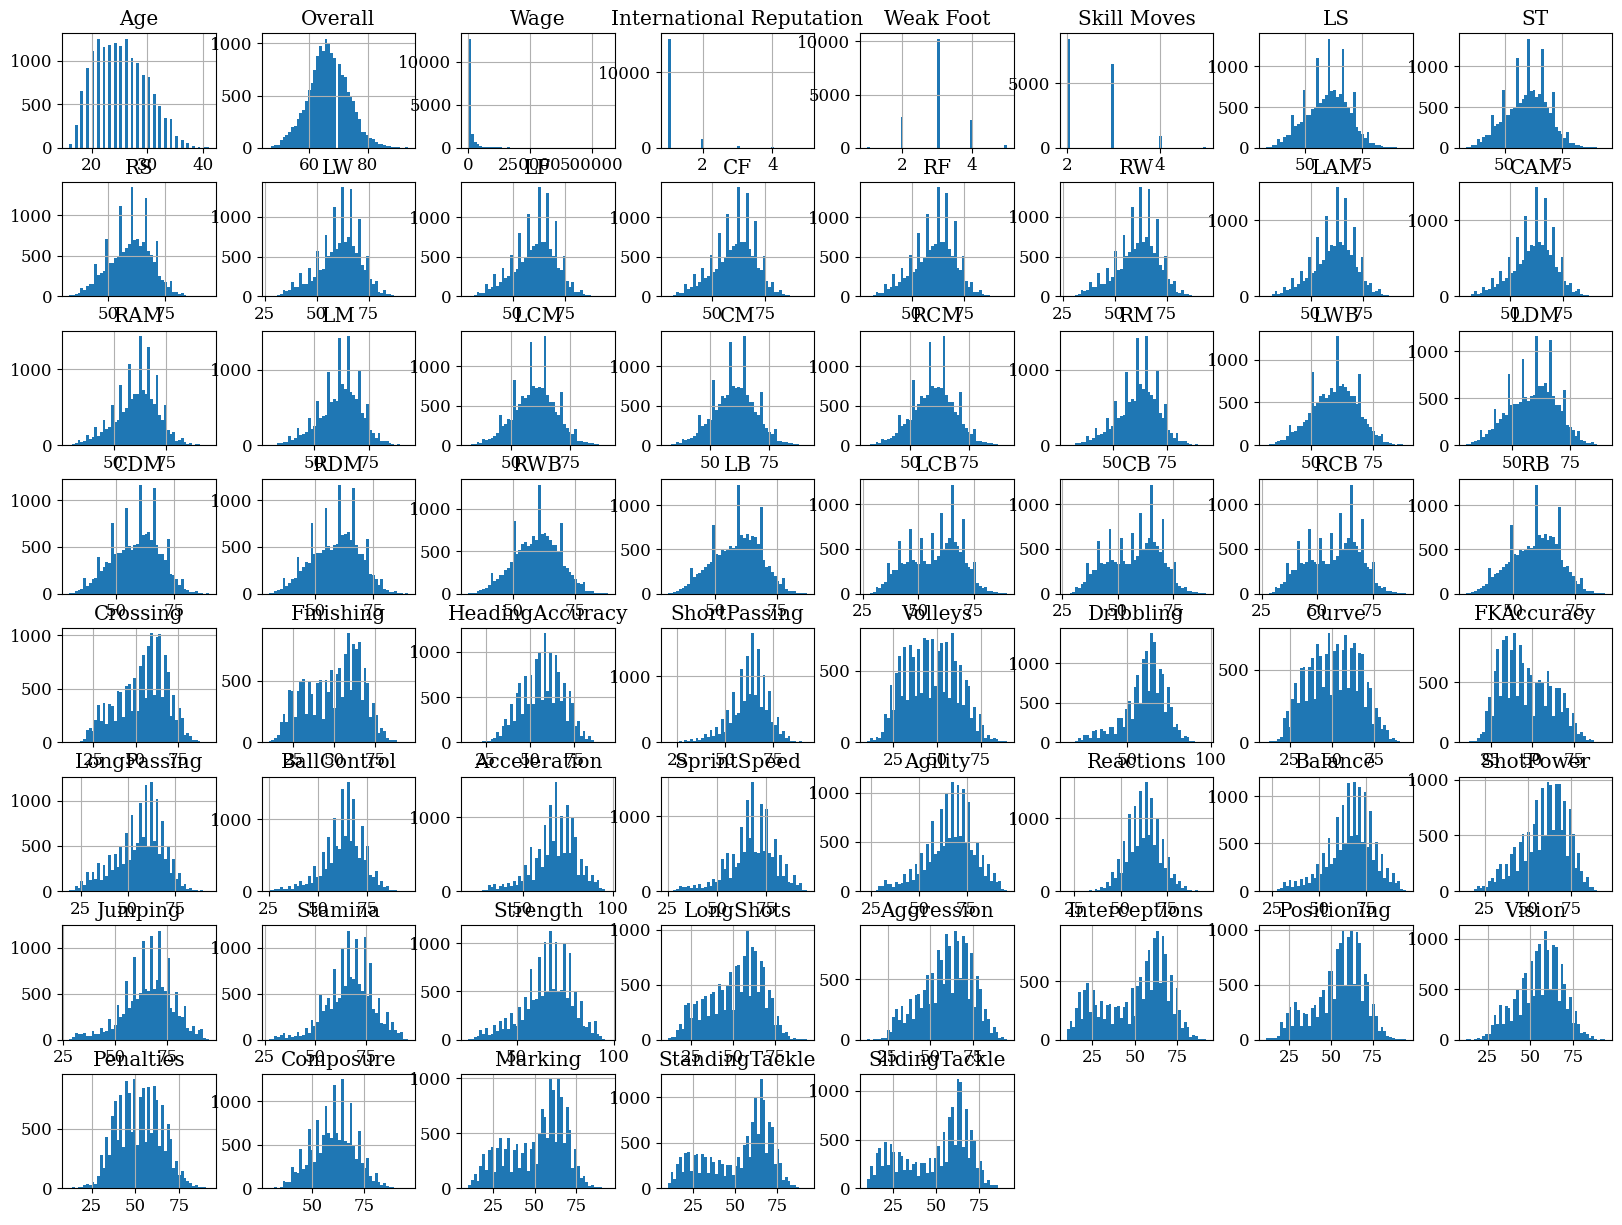

In [ ]:
#Veamos la distribución de las columnas
data.hist(bins=50, figsize=(20, 15));

In [ ]:
# Obtengamos la distribución de valores de la variable `Preferred Foot`:
# tip: pandas function value_counts()
data['Preferred Foot'].value_counts()


Right    11969
Left      3957
Name: Preferred Foot, dtype: int64

In [ ]:
# Dado que esta columna es categorica, debemos incluir en el Pipeline su transformación. Utilizaremos
# codificación binaria
#tip: scikit-learn BinaryEncoder -> Igual funcionamiento a OrdinalEncoder


categorical_features = ['Preferred Foot']

# Define los transformers para las columnas
numeric_transformer = Pipeline(steps=[
    # Agrega aquí cualquier otro preprocesamiento necesario para las columnas numéricas
    ('scaler', StandardScaler())  # Por ejemplo, estandarización con StandardScaler
])

categorical_transformer = Pipeline(steps=[
    # Usa BinaryEncoder para codificar la columna categórica 'Preferred Foot'
    ('binary_encoder', BinaryEncoder(cols=['Preferred Foot']))
])

# Combina los transformers en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
       ('cat', categorical_transformer, categorical_features)
    ])

## Regresión

**Nota:** Dejaremos la coulmna `Name` en el datafrme para poder identificar a los jugadores, pero **la debemos excluir** al definir las variables `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, and `y_test`.

In [ ]:
# Separemos los datos en conjuntos de entrenamiento (80 %) y prueba (20 %):
X = data.drop(columns=['Name','Wage'])
y = data['Wage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [ ]:
#Definimos las transformaciones
cat_cols = X_train.select_dtypes(include=object).columns
num_cols = X_train.select_dtypes(include=np.number).columns

categorical_transformer = Pipeline(steps=[
    ('binary_encoder', BinaryEncoder(cols=cat_cols))
])
numerical_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

#Definimos nuestro regresor
rf_base = RandomForestRegressor(random_state=random_state)
gb_base = GradientBoostingRegressor(random_state=random_state)

#Definimos los pipelines
pipeline_rf = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', rf_base),
                            ])
pipeline_gb =Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', gb_base),
    ])

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid =param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': list(range(6, 10)),
    'regressor__min_samples_leaf': [10, 300, 2000]
}

# Definamos nuestros modelo mediante GridSearchCV:
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid)
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid)

In [ ]:
%%time
# Entrenemos el random forest:
rf.fit(X_train, y_train)

CPU times: user 5min 53s, sys: 409 ms, total: 5min 53s
Wall time: 5min 56s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         Index(['Age', 'Overall', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
       'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing'...
       'Marking', 'StandingTackle', 'SlidingTackle'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('binary_encoder',
                                                                                          BinaryEncoder(cols=Index(['Preferred Foot'], dtype='object')))]),
                                                                         Index(['Preferred Foot'], dtype='object'))])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [6, 7, 8, 9],
                         'regressor__min_samples_leaf': [10, 300, 2000],
                         'regressor__n_estimators': [50, 100]})

In [ ]:
%%time
# Entrenemos el gradient boosting:
gb.fit(X_train, y_train)

CPU times: user 10min 9s, sys: 556 ms, total: 10min 9s
Wall time: 10min 12s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         Index(['Age', 'Overall', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
       'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing'...
       'Marking', 'StandingTackle', 'SlidingTackle'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('binary_encoder',
                                                                                          BinaryEncoder(cols=Index(['Preferred Foot'], dtype='object')))]),
                                                                         Index(['Preferred Foot'], dtype='object'))])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [6, 7, 8, 9],
                         'regressor__min_samples_leaf': [10, 300, 2000],
                         'regressor__n_estimators': [50, 100]})

In [ ]:
print(rf.best_params_)
print(gb.best_params_)

{'regressor__max_depth': 8, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 50}
{'regressor__max_depth': 6, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 50}


In [ ]:
# Obtengamos el R^2 y el MAE de entrenamiento para cada modelo:
print("Train set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_train, y_train)}')
    print(f'MAE: {mean_absolute_error(y_train, model.predict(X_train))}')
    print('\n')

print("Test set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_test, y_test)}')
    print(f'MAE: {mean_absolute_error(y_test, model.predict(X_test))}')
    print('\n')

Train set
Model: Random Forest
R^2: 0.832298973791454
MAE: 4170.168362807364


Model: Gradient Boosting
R^2: 0.9008905464935486
MAE: 3724.0274088205706


Test set
Model: Random Forest
R^2: 0.7796793023093568
MAE: 4747.375524234762


Model: Gradient Boosting
R^2: 0.7842995092307057
MAE: 4733.454878591794




In [ ]:
# Veamos los datos junto con las predicciones:
pd.concat([
    data.drop(columns='Wage').reset_index(drop=True),
    data['Wage'].reset_index(drop=True),
    pd.DataFrame({'rf_predicted_wage': rf.predict(data.drop(columns=['Name', 'Wage']))}),
    pd.DataFrame({'gb_predicted_wage': gb.predict(data.drop(columns=['Name', 'Wage']))})
], axis=1)

,Name,Age,Overall,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,...,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Wage,rf_predicted_wage,gb_predicted_wage
0,L. Messi,31,94,Left,5.0,4.0,4.0,90.0,90.0,90.0,...,94.0,94.0,75.0,96.0,33.0,28.0,26.0,565000,297521.493056,329238.805747
1,Cristiano Ronaldo,33,94,Right,5.0,4.0,5.0,94.0,94.0,94.0,...,95.0,82.0,85.0,95.0,28.0,31.0,23.0,405000,295231.950572,376613.981214
2,Neymar Jr,26,92,Right,5.0,5.0,5.0,87.0,87.0,87.0,...,89.0,87.0,81.0,94.0,27.0,24.0,33.0,290000,297521.493056,310379.559388
3,K. De Bruyne,27,91,Right,4.0,5.0,4.0,85.0,85.0,85.0,...,87.0,94.0,79.0,88.0,68.0,58.0,51.0,355000,297521.493056,340445.337484
4,E. Hazard,27,91,Right,4.0,4.0,4.0,86.0,86.0,86.0,...,87.0,89.0,86.0,91.0,34.0,27.0,22.0,340000,297521.493056,324918.106145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15921,J. Lundstram,19,47,Right,1.0,2.0,2.0,44.0,44.0,44.0,...,39.0,52.0,43.0,45.0,40.0,48.0,47.0,1000,1100.427370,1619.661953
15922,N. Christoffersson,19,47,Right,1.0,2.0,2.0,47.0,47.0,47.0,...,46.0,33.0,43.0,42.0,22.0,15.0,19.0,1000,1111.989645,1619.661953
15923,B. Worman,16,47,Right,1.0,3.0,2.0,47.0,47.0,47.0,...,48.0,43.0,55.0,41.0,32.0,13.0,11.0,1000,1118.197063,1619.661953
15924,D. Walker-Rice,17,47,Right,1.0,3.0,2.0,49.0,49.0,49.0,...,44.0,47.0,50.0,46.0,20.0,25.0,27.0,1000,1100.427370,1619.661953


Explicabilidad

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.4 MB/s eta 0:00:00


In [ ]:
import shap
from IPython.display import HTML

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
# Entrenamos nuestro pipeline con los mejores parámetros encontrados en la validación cruzada
pipeline_gb.set_params(**gb.best_params_)
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['Age', 'Overall', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
       'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPas...
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('binary_encoder',
                                                                   BinaryEncoder(cols=Index(['Preferred Foot'], dtype='object')))]),
                                                  Index(['Preferred Foot'], dtype='object'))])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=6, min_samples_leaf=10,
                                           n_estimators=50, random_state=42))])

In [ ]:
# Aplicamos el preproceso a los datos
X_train_preprocessed = pipeline_gb.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed = pipeline_gb.named_steps['preprocessor'].transform(X_test)

In [ ]:
y_est = pipeline_gb.predict(X_train)
Efx = np.mean(y_est)

In [ ]:
# Entrenemos nuestro modelo de explicabilidad
gb_explainer =shap.TreeExplainer(pipeline_gb.named_steps["regressor"])
train_gb_shap_values = gb_explainer.shap_values(X_train_preprocessed)

In [ ]:
train_gb_shap_values[1].shape

(62,)

In [ ]:
test_gb_shap_values = gb_explainer.shap_values(X_test_preprocessed)
test_gb_shap_values[1].shape

(62,)

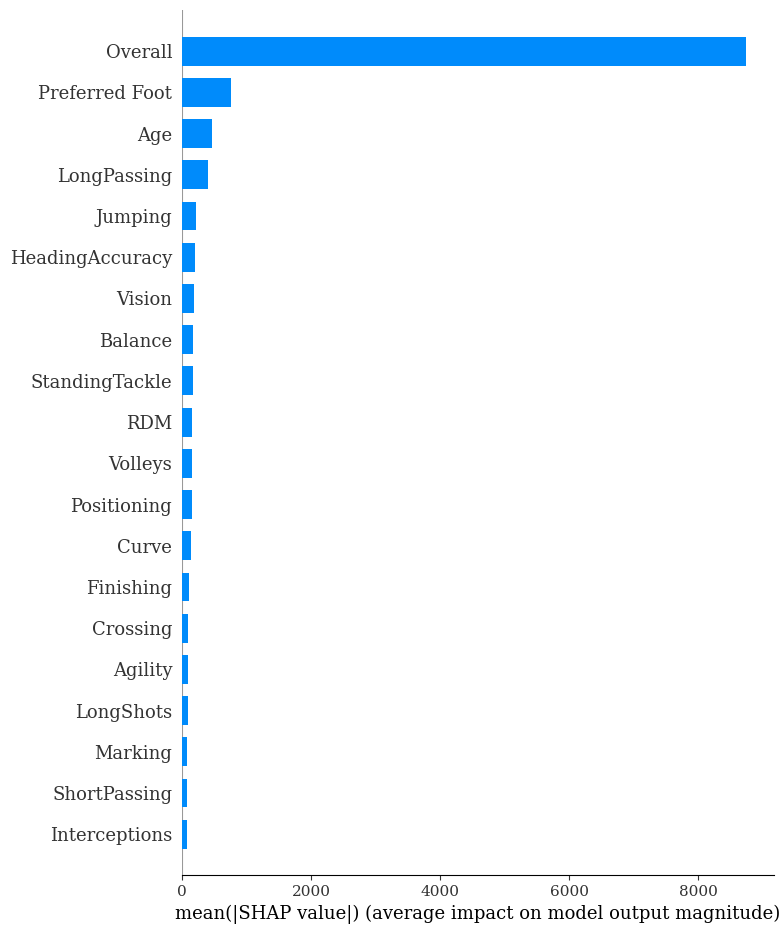

In [ ]:
# Summary plot
shap_values = test_gb_shap_values[:, :-1]
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
# Grafiquemos los valores SHAP para un ejemplo del conjunto de test

shap.initjs()

# Luego, llama a shap.force_plot con shap_values_without_base.
instance_index = 2  # Índice de la instancia que deseas visualizar
force_plot_html = shap.force_plot(gb_explainer.expected_value, shap_values[instance_index], X_test.iloc[instance_index], show=False)
HTML(force_plot_html.html())

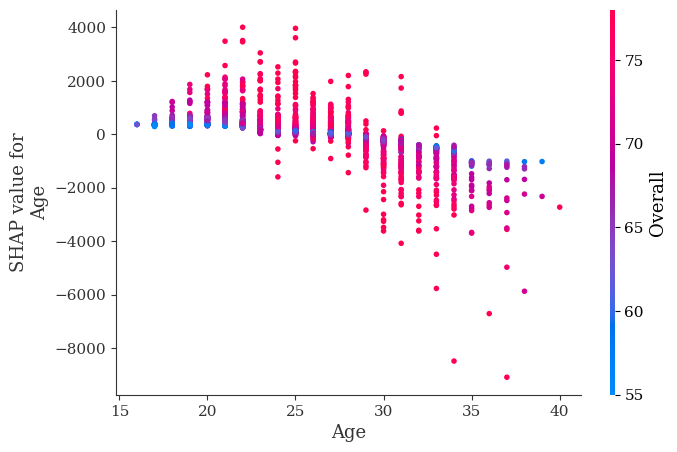

In [ ]:
# Grafiquemos la dependencia de los valores SHAP con la variable "Age"
shap.dependence_plot('Age', shap_values, X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


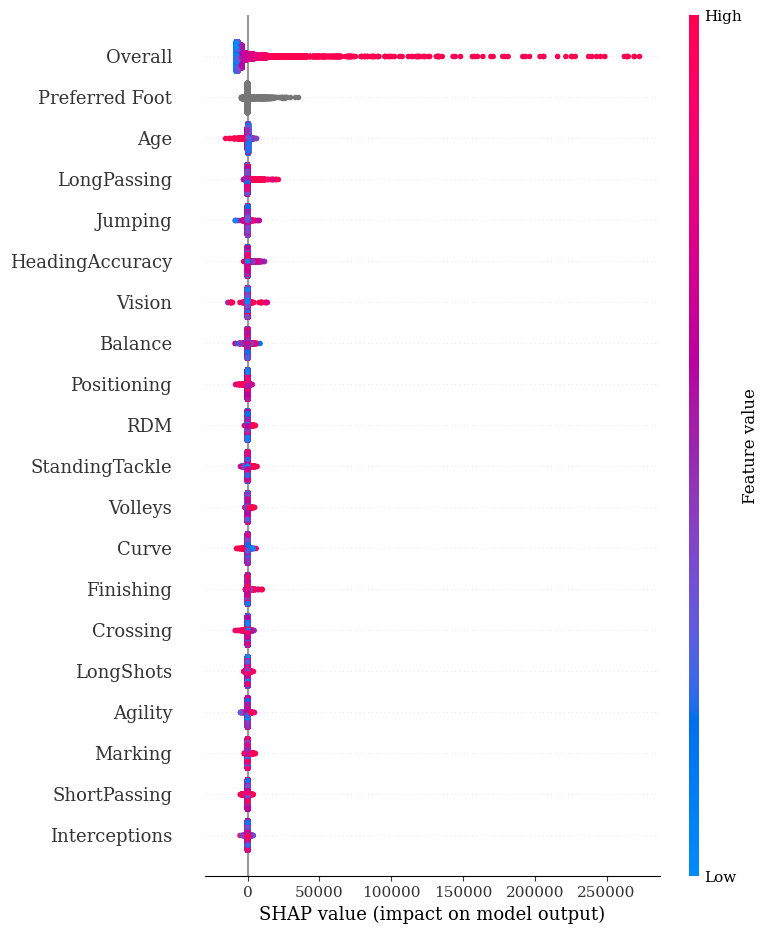

In [ ]:
#Summary plot
train_shap_values = train_gb_shap_values[:, :-1]
shap.summary_plot(train_shap_values, X_train)